In [1]:
import json, os
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches, patheffects
import numpy as np
import seaborn as sns
import pandas as pd
from skimage.measure import block_reduce
import urllib.request
import imageio
from tqdm import tqdm_notebook as tqdm

## Cloud dataset - basic setup

In [4]:
IMG_PATH = '/local/S.Rasp/MPI_Aqua/raw/'

In [5]:
with open('labelbox_annotations/labelbox_0821.json', 'r') as f:
    data_new = json.load(f)

In [6]:
# Get all unique image fns
fns = list(set([d['External ID'] for d in data_new]))

In [23]:
sz = np.array(Image.open(IMG_PATH+fns[0])).shape[:-1]; sz

(1144, 1140)

In [8]:
labeler = {d['External ID']: d['Created By'] for d in data_new}

In [11]:
MASK_PATH = '/local/S.Rasp/MPI_Aqua/masks/raw/'

In [12]:
labels = defaultdict(list)
for d in data_new:
    cats = d['Label']
    l = d['Created By']
    fn = d['External ID']
    if 'No fit' in cats.keys():
        labels[fn] = []
    else:
        for i, c in enumerate(list(cats.keys())):
            xs = [cats[c][0]['geometry'][i]['x'] for i in range(4)]
            ys = [cats[c][0]['geometry'][i]['y'] for i in range(4)]
#             bl_x = d['Label'][c][0]['geometry'][1]['x']
#             bl_y = d['Label'][c][0]['geometry'][1]['y']
#             tr_x = d['Label'][c][0]['geometry'][3]['x']
#             tr_y = d['Label'][c][0]['geometry'][3]['y']
            bl_x = np.min(xs); bl_y = np.min(ys)
            tr_x = np.max(xs); tr_y = np.max(ys)
            msk_fn = MASK_PATH + fn[:-4] + f'_m{i}.png'
            print(msk_fn)
            if not os.path.exists(msk_fn):
                print('Downloading')
                urllib.request.urlretrieve(d['Masks'][c], msk_fn)
            labels[fn].append([c, (bl_x, bl_y, tr_x, tr_y), l, msk_fn])

/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170228_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170227_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170218_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170216_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170212_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170210_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170209_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170209_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170208_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170208_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170207_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170207_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170206_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_

In [13]:
# Count classes
classes = [list(d['Label'].keys()) for d in data_new if d['Label'] != 'Skip']
classes = [item for sublist in classes for item in sublist]

In [14]:
classes = pd.Series(classes)

In [15]:
classes.value_counts()

Shallow      385
No fit       284
Cold pool    198
Flower       168
Fishbone     118
dtype: int64

In [16]:
def bb_hw(a): return np.array([a[0],a[1],a[2]-a[0],a[3]-a[1]])

In [17]:
def show_img(fn, ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=(10,10))
    img = Image.open(IMG_PATH + fn)
    ax.imshow(np.flipud(img), origin='lower')
    for l in labels[fn]:
        bb = bb_hw(l[1])
        patch = ax.add_patch(
            patches.Rectangle(bb[:2], *bb[-2:], fill=False, edgecolor='red', lw=2))
#         print(l[1], bb)
        text = ax.text(*bb[:2], l[0] + ' ' + l[2], horizontalalignment='left',
                verticalalignment='bottom', color='red', fontsize=15, weight='bold')

In [18]:
cats = list(set(classes)); cats

['Flower', 'Fishbone', 'Shallow', 'Cold pool', 'No fit']

In [19]:
cats

['Flower', 'Fishbone', 'Shallow', 'Cold pool', 'No fit']

In [20]:
cat2id = {c: i for i, c in enumerate(cats)}

## Prepare the masks

In [21]:
cat2id

{'Flower': 0, 'Fishbone': 1, 'Shallow': 2, 'Cold pool': 3, 'No fit': 4}

In [24]:
for fn, l in tqdm(labels.items()):
    
    ms = []
    for ll in l:
        bb = ll[1]
        m = np.zeros(sz)
        m[bb[1]:bb[3],bb[0]:bb[2]] = cat2id[ll[0]]
        ms.append(m)
    if len(l) > 1:
        ms_bin = [np.greater(m, 0) for m in ms]
        ms = np.array(ms)
        ms_bin = np.array(ms_bin)
        overlap = np.equal(np.mean(ms, 0), ms[0])
        tot_msk = np.mean(ms, 0)
        too_many = (overlap == 0) & (np.sum(ms_bin, 0) > 1)
        one_cat  = (overlap == 0) & (np.sum(ms_bin, 0) == 1)
        tot_msk[too_many] = 0; tot_msk[one_cat] = np.max(ms, 0)[one_cat]
    elif len(l) == 1:
        tot_msk = m
    else:
        tot_msk = np.zeros(sz)
    tot_msk = np.flipud(tot_msk.astype('uint8'))
    imageio.imsave(MASK_PATH + fn, tot_msk)

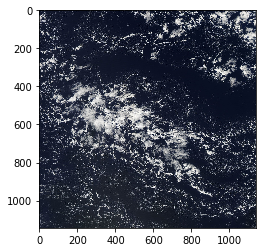

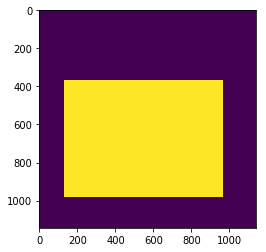

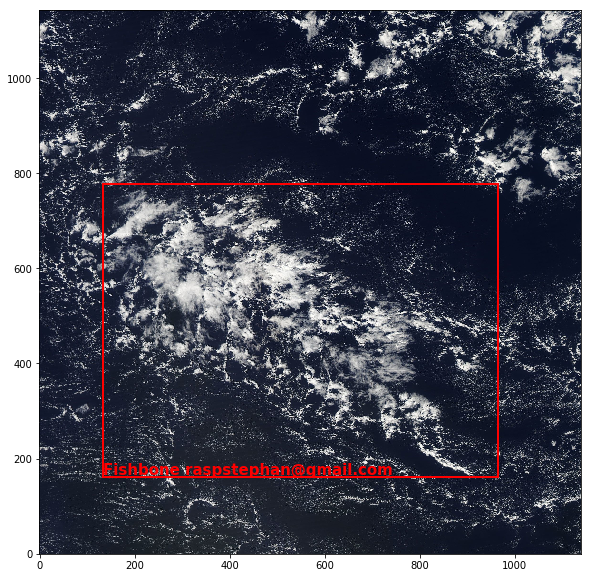

In [27]:
fn = fns[5]
plt.imshow(Image.open(IMG_PATH + fn)); plt.show()
plt.imshow(np.array(Image.open(MASK_PATH + fn))); plt.show()
show_img(fns[5])

### convert

In [28]:
cat2id

{'Flower': 0, 'Fishbone': 1, 'Shallow': 2, 'Cold pool': 3, 'No fit': 4}

In [30]:
for fn in tqdm(fns):
    m = np.array(Image.open(MASK_PATH + fn))
    m2 = np.zeros(sz, dtype='uint8')
    #for i in range(1, 5):
    m2[m==cat2id['Shallow']] = 1
    imageio.imsave(MASK_PATH + fn[:-4] + '_mask_shallow.png', m2)

## Unet

In [89]:
import tensorflow as tf
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator

we create two instances with the same arguments
```
    data_gen_args = dict(featurewise_center=True,
                         featurewise_std_normalization=True,
                         rotation_range=90.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.2)
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    # Provide the same seed and keyword arguments to the fit and flow methods
    seed = 1
    image_datagen.fit(images, augment=True, seed=seed)
    mask_datagen.fit(masks, augment=True, seed=seed)

    image_generator = image_datagen.flow_from_directory(
        'data/images',
        class_mode=None,
        seed=seed)

    mask_generator = mask_datagen.flow_from_directory(
        'data/masks',
        class_mode=None,
        seed=seed)

    # combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)

    model.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=50)
```

In [98]:
data_gen_args = dict(rotation_range=15.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     validation_split=0.1
                     )
image_datagen = ImageDataGenerator(**data_gen_args, rescale=1./255.)
mask_datagen = ImageDataGenerator(**data_gen_args, )

In [99]:
seed = 1
bs=16

In [100]:
train_generator = zip(
    image_datagen.flow_from_directory(
        IMG_PATH,
        batch_size=bs,
        target_size=(256,256),
        class_mode=None,
        seed=seed,
        subset='training'
    ),
    mask_datagen.flow_from_directory(
        '/local/S.Rasp/MPI_Aqua/masks/shallow/',
        batch_size=bs,
        target_size=(256,256),
        class_mode=None,
        seed=seed,
        subset='training',
        color_mode='grayscale'
    )
)

Found 813 images belonging to 1 classes.
Found 813 images belonging to 1 classes.


In [101]:
valid_generator = zip(
    image_datagen.flow_from_directory(
        IMG_PATH,
        batch_size=bs,
        target_size=(256,256),
        class_mode=None,
        seed=seed,
        subset='validation'
    ),
    mask_datagen.flow_from_directory(
        '/local/S.Rasp/MPI_Aqua/masks/shallow/',
        batch_size=bs,
        target_size=(256,256),
        class_mode=None,
        seed=seed,
        subset='validation',
        color_mode='grayscale'
    )
)

Found 90 images belonging to 1 classes.
Found 90 images belonging to 1 classes.


In [104]:
# https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [105]:
# Build U-Net model
inputs = Input((256, 256, 3))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 8)  224         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 8)  584         conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 8)  0           conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_41 

In [106]:
813//16, 90//16

(50, 5)

In [120]:
model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=50,
    validation_data=valid_generator,
    validation_steps=5
)

Epoch 1/50
50/50 [==============================] - 51s 1s/step - loss: 0.3516 - mean_iou: 0.4412 - val_loss: 0.2427 - val_mean_iou: 0.4407
Epoch 2/50
50/50 [==============================] - 47s 932ms/step - loss: 0.3450 - mean_iou: 0.4410 - val_loss: 0.1923 - val_mean_iou: 0.4407
Epoch 3/50
50/50 [==============================] - 47s 943ms/step - loss: 0.3326 - mean_iou: 0.4409 - val_loss: 0.1754 - val_mean_iou: 0.4408
Epoch 4/50
50/50 [==============================] - 48s 954ms/step - loss: 0.3191 - mean_iou: 0.4410 - val_loss: 0.1637 - val_mean_iou: 0.4411
Epoch 5/50
50/50 [==============================] - 48s 964ms/step - loss: 0.3142 - mean_iou: 0.4414 - val_loss: 0.2054 - val_mean_iou: 0.4412
Epoch 6/50
50/50 [==============================] - 48s 956ms/step - loss: 0.3167 - mean_iou: 0.4412 - val_loss: 0.2420 - val_mean_iou: 0.4413
Epoch 7/50
50/50 [==============================] - 48s 964ms/step - loss: 0.3081 - mean_iou: 0.4414 - val_loss: 0.1710 - val_mean_iou: 0.4414
Ep

KeyboardInterrupt: 

In [155]:
X, Y = next(train_generator)

In [156]:
preds = model.predict(X)

In [157]:
X.shape, Y.shape, preds.shape

((16, 256, 256, 3), (16, 256, 256, 1), (16, 256, 256, 1))

In [158]:
Y[0].shape

(256, 256, 1)

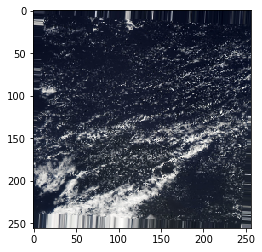

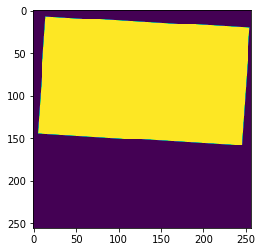

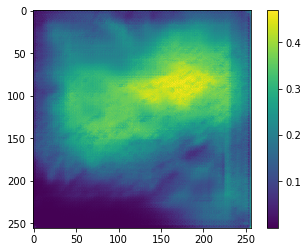

In [172]:
i=11
plt.imshow(X[i]); plt.show()
plt.imshow(Y[i, :, :, 0]); plt.show()
plt.imshow(preds[i, :, :, 0]); plt.colorbar(); plt.show()